In this notebook, we will generate some noisy data from a plane, then write and train a linear regression model to learn the data.

In [1]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt

Write a method called `generate_data` that generates some data according to the following distributions:
$$X_1 \sim \mathcal{N}(0, 10),$$
$$X_2 \sim \mathcal{N}(0, 10),$$
$$y = 3X_1 - 2X_2 + \mathcal{N}(0, 5).$$
It should take `n_samples` as a parameter and return two `np.ndarray`s, one of shape `(n_samples, 2)` and another of shape `(n_samples, )`.

In [2]:
def generate_data(n_samples, coefficients=(3, -2), bias=0):
    X = np.random.normal(0, 10, size=(n_samples, 2))
    y = X @ np.array(coefficients) + bias + np.random.normal(0, 10, size=n_samples)
    return X, y

n_samples = 1000
X_train, y_train = generate_data(n_samples)
assert X_train.shape == (n_samples, 2)
assert y_train.shape == (n_samples, )


Plot the training data in 3D using `matplotlib`.

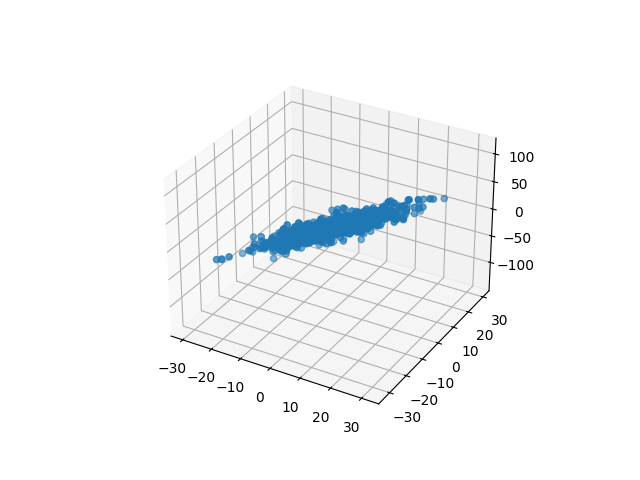

In [3]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(X_train[:, 0], X_train[:, 1], y_train)
plt.show()

We will build a simple model to learn this data. Roughly speaking, it will take in this training data and try to figure out the equation of the plane, and as a result, given brand new `(x_1, x_2)` values, it will be able to predict their `y` values.

To evaluate our model, we will use the mean-squared-error of our predictions. A "normalized" version of this is `R^2 = 1 - MSE / variance of y_true`, which is always between 0 and 1.

In [4]:
def MSE(y_true, y_pred):
    residues = y_true - y_pred
    return residues @ residues.T / len(y_true)

def R2(y_true, y_pred):
    return 1 - MSE(y_true, y_pred) / y_true.var()

y_true = np.array([1, 5])
y_pred = np.array([2, 4])
assert MSE(y_true, y_pred) == 1
assert R2(y_true, y_pred) == 1 - 1 / 4

Now let us build our model. We can model a plane by $\beta X$ for some vector $\beta.$ To find $\beta,$ we minimize
$$\text{MSE}(\beta X, y) = (\beta X - y)^T (\beta X - y).$$
Soon we will see that this amounts to setting the derivative equal to zero and solving for beta:
$$\beta = (X^TX)^{-1} X^T y.$$
(For example, see https://en.wikipedia.org/wiki/Linear_regression#Least-squares_estimation_and_related_techniques.)

Write a `LR` class that does this. It should have one attribute `beta` and two methods `fit` and `predict`. The `fit` method should take in training data `X` and `y` and determine `beta`, and the `predict` method should take in new data `X_test` and output its predictions. In particular, the `predict` method should assume that the model has already been fit to some training data.

In [5]:
def concat_ones(X):
    # Add a 1 in front of every training sample for the bias term.
    return np.concatenate([np.ones(shape=(len(X), 1)), X], axis=1)

assert (
    concat_ones(np.array([
        [2, 3, 4, 5],
        [6, 7, 8, 9],
        [1, 2, 3, 4]
    ])) == np.array([
        [1, 2, 3, 4, 5],
        [1, 6, 7, 8, 9],
        [1, 1, 2, 3, 4]
    ])
).all()


class LR:
    def __init__(self, learn_bias=False):
        self.beta = None
        self.learn_bias = learn_bias

    def fit(self, X, y):
        if self.learn_bias:
            X = concat_ones(X)
        self.beta = np.linalg.inv(X.T @ X) @ X.T @ y

    def predict(self, X_test):
        if self.learn_bias:
            X_test = concat_ones(X_test)
        if self.beta is None:
            raise ValueError('Fit the LR model before predicting.')
        return X_test @ self.beta
    
model = LR()

Finally, generate some training data, train a LR model on it, generate some test data, and evaluate how well the model does on the test data. 

In [6]:
# generate some training data
n_samples = 1000
dim = 2
X_train, y_train = generate_data(n_samples, bias=20)

# train a LR model on the training data
model = LR(learn_bias=True)
model.fit(X_train, y_train)

# generate some test data
X_test, y_test = generate_data(n_samples, bias=20)

# evaluate how well the model does on the test data
y_pred = model.predict(X_test)
print(f'R^2 = {R2(y_test, y_pred)}')

R^2 = 0.9230417475378355


Bonus: So far we have only considered data coming from planes that pass through the origin. There is a clean way to learn a bias term: add an extra `1` in front of your training data, i.e. change `(x_1, x_2)` to `(1, x_1, x_2)`, then increase the size of your `beta` vector by one. The `beta_0` term is then your bias term!

Alter `generate_data` to take in an optional bias parameter: `generate_data(n_samples, bias=0)`. Then, alter your `LR` class to learn a bias term as well.